In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import os, time, datetime
from matplotlib import pyplot as plt

News in the website www.intopic.it have a publishing date which is written in italian using a non-standard format. Use the following function to convert it into a datetime.

In [2]:
def extract_date(filename, raw_string):
    raw_string = str(raw_string)
    months = {'Gennaio':'01', 'Febbraio':'02', 'Marzo':'03', 'Aprile':'04', 'Maggio':'05'}

    if "2020" in raw_string:
        creation_date = raw_string.split(' ')
        form_date = str(creation_date[3]) +'-'+ str(months[creation_date[2]]) + '-' + str(creation_date[1])
        #print(form_date)
    else:
        #print(raw_string)
        creation_date = time.ctime(os.path.getctime(filename))
        form_date = str(datetime.datetime.strptime(creation_date, "%a %b %d %H:%M:%S %Y"))
        form_date = form_date.split(' ')[0]
        #print(form_date)
    
    return form_date


Now let us start with the code for our analysis.

In [3]:
# Setup variables
html_root = "/home/marco/workspace/git/StatLearnTeam/web_pages_index/" # Where the html pages are

cols = ['title', 'content', 'date', 'author', 'tags']
articles_df = pd.DataFrame(data = None, columns = cols)



for i in (list(range(1, 1000))[::-1]): # From last page to most recent
    
    webpage_path = html_root + str(i) + ".html"
    html_content = open(webpage_path)
    soup = BeautifulSoup(html_content, 'html.parser') # Open file as a webpage
    
    ################# SINGLE PAGE MINING STARTS HERE #############################
    
    article_section = soup.findAll('div', attrs={"class":"bp-entry"})
    for article in article_section:
        try:
            title = article.find("h2").find("a").getText()
            content = article.find("div", attrs = {"class":"bp-details"}).getText()
            publication_info = article.find("span", attrs = {"class":"author vcard"}) # Date, author...
            
            date = extract_date(webpage_path, str(publication_info.getText()))
            
            author = publication_info.find("span", attrs={"class":"fn"}).getText()
            
            # Not all articles have tags, but should not be a problem getting the other info (always useful)
            # That's why there is a nested try except.
            tags = list()
            try:
                tags_raw = article.find("div", {"class":"tagcloud"}).findAll("a",{'class':'tag-link-10'})
                tags.extend([tag.getText() for tag in tags_raw])
            except:
                pass # Not an article, OR the article does not have any tags
            
            article_entry = pd.DataFrame(data = [[title, content, date, author, tags]], columns = cols)
            articles_df = articles_df.append(article_entry, ignore_index = True)

        except Exception as e:
            pass # Not all html element retrieved are actually article so exceptions could be thrown.
            #print(e)
            #print("=" * 10)
            #print("\nNOT AN ARTICLE!\n")
            #print(article)
            #print("\n" * 3)

Now let's preview the dataset we have generated. 

In [4]:
articles_df

,title,content,date,author,tags
0,"Live Non è la DUrso, Nina Moric si sottopone ...",\n\nNell'ultima puntata di Live non è la D'Urs...,2020-02-17,Il Fatto Quotidiano,[]
1,"Tamponamento tra auto e pullman, incidente sul...",\n\nGrave incidente stradale sulla A3 Napoli-S...,2020-02-17,Torresette,"[Incidenti Stradali, Campania, Torre Annunziat..."
2,Badante cilentana abbandona cadavere in strada...,\n\nHanno rinvenuto il cadavere di un 84enne r...,2020-02-17,Salernonotizie,"[Grottaminarda, Campania, Benevento]"
3,"Torna la neve, ma è in agguato il super caldo",\n\nSegui su affaritaliani.it Articolo complet...,2020-02-17,Affaritaliani,[Neve]
4,"Tragedia a Madonna di Campiglio, mercoledì l'a...",\n\nCIVITANOVA - Tornerà domani pomeriggio a C...,2020-02-17,Corriere Adriatico,[]
...,...,...,...,...,...
14980,Tragedia in casa: bimbo di 18 mesi ingoia una ...,\n\nSICILIA - Un bimbo di 18 mesi di Pietraper...,2020-03-28,Il Meridiano News,"[Sicilia, Pietraperzia, Enna, Caltanissetta]"
14981,Coronavirus: controlli della Polizia Locale su...,"\n\nCagliari, 24 Mar 2020 - Dopo un'attenta an...",2020-03-28,Cronaca on line,"[Polizia, Sardegna, Cagliari]"
14982,Chi può fermare lepidemia di Covid-19? Lo s...,\n\n\n\nChi può fermare la diffusione del Coro...,2020-03-28,Il Valore Italiano,"[Epidemie, Coronavirus, Video, Polizia, YouTube]"
14983,"Coronavirus, scrive sullautocertificazione d...",\n\n\n\nDeve aver pensato che dichiarare la ve...,2020-03-28,Il Fatto Quotidiano,"[Frattamaggiore, Campania, Napoli]"


### We shall now get some insight on the content of the articles. Let's look up some virus-related keywords and see if they appear in the articles.

In [5]:
######################## DATAFRAME ANALYSIS STARTS HERE ######################    
contains_virus_count = {}

for i in range(0, len(articles_df)):
    row = articles_df.values[i]
    
    title = row[0]
    content = row[1]
    date = row[2]
    author = row[3]
    tags = row[4]
    
    aggregate_fields = [title, content]
    aggregate_fields.extend(tags)
    
    if date not in contains_virus_count.keys():
        contains_virus_count[date] = 0

    keywords = ['coronavirus', 'covid', 'covid-19']            
    has_keyword = False # Until proven true
    
    for field in aggregate_fields:
        
        if any(k in str.lower(field) for k in keywords):
            has_keyword = True
            
    if has_keyword:
        contains_virus_count[date] = contains_virus_count[date] + 1  # 1 More article contains coronavirus related keywords

In [6]:
contains_virus_count

{'2020-02-17': 13,
 '2020-02-18': 22,
 '2020-02-19': 10,
 '2020-02-20': 15,
 '2020-02-21': 35,
 '2020-02-22': 105,
 '2020-02-23': 46,
 '2020-02-24': 135,
 '2020-02-25': 82,
 '2020-02-26': 104,
 '2020-02-27': 54,
 '2020-02-28': 48,
 '2020-02-29': 39,
 '2020-03-1': 25,
 '2020-03-2': 104,
 '2020-03-3': 89,
 '2020-03-4': 93,
 '2020-03-5': 77,
 '2020-03-6': 95,
 '2020-03-7': 90,
 '2020-03-8': 102,
 '2020-03-9': 214,
 '2020-03-10': 161,
 '2020-03-11': 224,
 '2020-03-12': 188,
 '2020-03-13': 189,
 '2020-03-14': 182,
 '2020-03-15': 168,
 '2020-03-16': 186,
 '2020-03-17': 199,
 '2020-03-18': 260,
 '2020-03-19': 219,
 '2020-03-20': 284,
 '2020-03-21': 217,
 '2020-03-22': 184,
 '2020-03-23': 248,
 '2020-03-28': 269}

That is a day by day count of articles that have the chosen keywords just in the title or content preview. 
Now the
# plotting

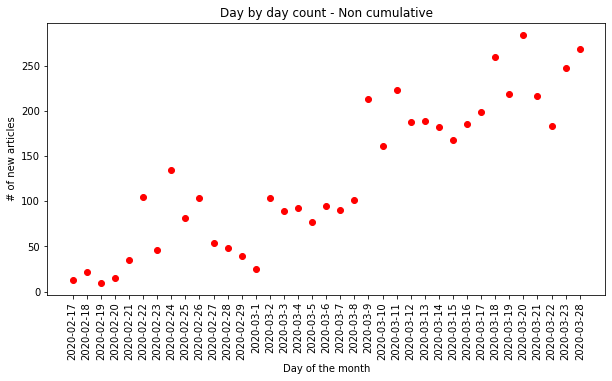

In [36]:
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

import numpy as np

plt.figure(figsize=(10, 5))
plt.xticks(rotation=90)       

dates = list(contains_virus_count.keys())
num_of_articles = list(contains_virus_count.values())

sum_articles = 0
total_num_of_articles = []
for v in num_of_articles:
    sum_articles += v
    total_num_of_articles.append(sum_articles)


plt.title("Day by day count - Non cumulative")
plt.xlabel("Day of the month")
plt.ylabel("# of new articles")

plt.scatter(dates, num_of_articles, color='r')
plt.show()

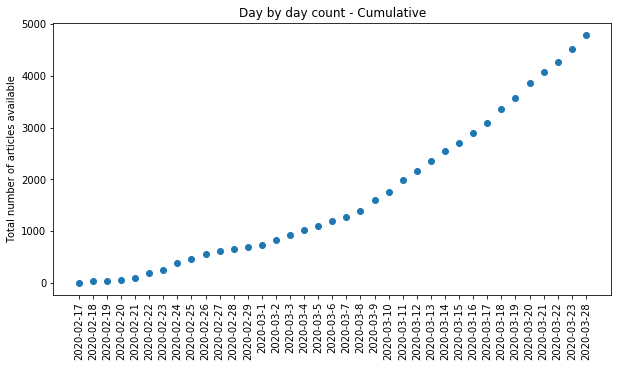

In [35]:
plt.figure(figsize=(10,5))
plt.xticks(rotation=90)
plt.ylabel("Total number of articles available")
plt.title('Day by day count - Cumulative')
plt.scatter(dates, total_num_of_articles)
plt.show()